# **Bias Measuring and Mitigation in Recommendation Systems**

Bias in recommendation systems can arise when the predictions systematically deviate from the true values for certain subgroups in the dataset. This phenomenon can be due to various reasons, such as unbalanced groups in the training data, feature selection, or model specification. A recommendation system aims to recommend the best items according to user preferences, but bias can affect the fairness and accuracy of these recommendations.

To address this, various techniques can be used to measure bias in recommendation systems. Common approaches include using fairness metrics such as aggregate diversity, exposure entropy, or the Gini index, which are item-based metrics that calculate the distribution of items shown to users.

Once bias is detected, we can employ different techniques to mitigate it. These methods can be grouped into three categories: Pre-processing, In-processing, and Post-processing. Pre-processing techniques adjust the training data to remove bias, In-processing methods build robust models against bias, and Post-processing techniques adjust the model's predictions to remove bias.

In this tutorial, we will demonstrate tools to measure and mitigate bias in recommender systems, focusing on predicting users' music preferences using the "Last FM Dataset." The outline of the tutorial is as follows:

1. [Data Loading and Packages Installation](#1-Data-Tasks-Loading-Exploration-and-Preprocessing)
2. [Data Exploration](#2-data-exploration)
3. [Model Training](#3-model-training)
4. [Bias Measurement](#4-bias-measurement)
5. [Bias Mitigation](#5-bias-mitigation)
    - [Blind Spot Aware Method](#Inprocessing-Blind-spot-aware-method)
    - [Debiasing learning method](#Inprocessing-Debiasing-Learning-Method)
6. [Results Comparison](#6-results-comparison)

## **1. Data Tasks: Loading, Exploration, and Preprocessing**

First, we need to import the required packages to perform our bias analysis and mitigation. Ensure you have the `holisticai` package installed on your system by running:

```bash
!pip install holisticai[all]
```

In [1]:
# Base Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
import warnings
warnings.filterwarnings("ignore")

## **2. Data exploration**

The dataset used is the "Last FM Dataset," which contains a set of artists downloaded by users, along with user information such as sex and country of origin. We will use the column "score," which contains 1s to count interactions.

Source: [GroupLens ](https://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt)

The load_dataset function from the holisticai package returns the preprocessed dataset. For the 'lastfm' dataset, it returns the processed pivot table as a numpy array and the protected attribute.

In [2]:
from holisticai.datasets import load_dataset

dataset = load_dataset('lastfm')
df_pivot, p_attr = dataset['data_pivot'], dataset['p_attr']

<Axes: >

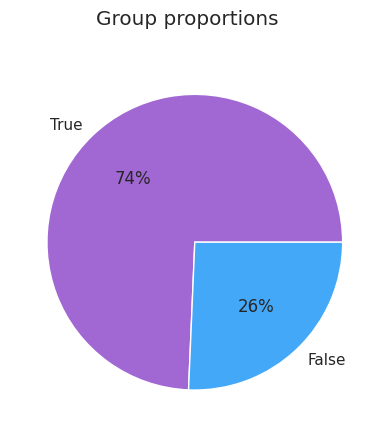

In [3]:
from holisticai.bias.plots import group_pie_plot

group_pie_plot(p_attr)

This graph shows that the proportion of non-protected examples is very high compared to the protected group.

In [4]:
print ('Number of Unique Users : ' + str(df_pivot.shape[0]))
print ('Number of Unique Artists : ' + str(df_pivot.shape[1]))

Number of Unique Users : 15000
Number of Unique Artists : 1004


## **3. Model training**

### **Training the baseline**
We will use item-based collaborative filtering to recommend artists to users. This approach involves finding the most similar artists and recommending them based on users' preferences.

In [5]:
def items_liked_by_user(data_matrix, u):
    return np.nonzero(data_matrix[u])[0]

def recommended_items(data_matrix, similarity_matrix, u, k):
    liked = items_liked_by_user(data_matrix, u)
    arr = np.sum(similarity_matrix[liked,:], axis=0)
    arr[liked] = 0
    return np.argsort(arr)[-k:]

def explode(arr, num_items):
    out = np.zeros(num_items)
    out[arr] = 1
    return out

We prepare our pivoted table to calculate correlations and perform filtering to create a new pivoted table for user recommendations.

In [6]:
from sklearn.metrics.pairwise import linear_kernel

data_matrix = df_pivot.fillna(0).to_numpy()
cosine_sim = linear_kernel(data_matrix.T, data_matrix.T)

new_recs = [explode(recommended_items(data_matrix, cosine_sim, u, 10), len(df_pivot.columns)) for u in range(df_pivot.shape[0])]
new_df_pivot = pd.DataFrame(new_recs, columns = df_pivot.columns)
new_df_pivot.head()

,...and you will know us by the trail of dead,2pac,3 doors down,30 seconds to mars,311,36 crazyfists,44,50 cent,65daysofstatic,Edith piaf,...,weezer,wilco,within temptation,wolfgang amadeus mozart,wu-tang clan,yann tiersen,yeah yeah yeahs,yellowcard,yo la tengo,zero 7
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finally, we obtain our recommendation matrix:

In [7]:
mat = new_df_pivot.replace(0,np.nan)

## **4. Bias Measurement**
We will calculate various fairness metrics for our recommendation matrix using the `recommender_bias_metrics` function:

In [8]:
from holisticai.bias.metrics import recommender_bias_metrics

df = recommender_bias_metrics(mat_pred=mat, metric_type='item_based')
df_baseline=df.copy()
df_baseline

,Value,Reference
Metric,,
Aggregate Diversity,0.416335,1
GINI index,0.964376,0
Exposure Distribution Entropy,3.811466,-
Average Recommendation Popularity,5725.218920,-


The function computes metrics such as Aggregate Diversity and Gini Index, helping us analyze fairness in recommendations.

## **5. Bias mitigation**

Now that we could observe that the model metrics are far away from the desired values, we need to apply some kind of strategy to mitigate the bias present in the model.

Exists different kinds of strategies, and the literature has divided them into three categories: "Pre-processing", "in-processing" and "post-processing" methods. The `holisticai` library possesses different algorithms from these categories for bias mitigation. An interesting feature is that all of them are compatible with the `Scikit-learn` package, so that, if you are familiar with this package, you will not have problems using the library.

### **Inprocessing: Blind spot aware method**

First, we will implement the "Blind spot aware" method which is a inprocessing algorithm that takes into account the blind spot inherent in the learning phase of the Recommender System. Where the blind spot size is the number of item with a predicted rating.

In [9]:
from holisticai.bias.mitigation import BlindSpotAwareMF

mf = BlindSpotAwareMF(K=40, beta=0.02, steps=10, alpha=0.002, lamda=0.008, verbose=1)
mf.fit(data_matrix)

We use the data matrix and protected groups to perform mitigation.

In [10]:
def recommended_items(model, data_matrix, k):
    recommended_items_mask = data_matrix>0
    candidate_index = ~recommended_items_mask
    candidate_rating = model.pred*candidate_index
    return np.argsort(-candidate_rating,axis=1)[:,:k]

new_items = recommended_items(mf, data_matrix, 10)
new_recs = [explode(new_items[u], len(df_pivot.columns)) for u in range(df_pivot.shape[0])]
new_df_pivot_db = pd.DataFrame(new_recs, columns = df_pivot.columns)

mat = new_df_pivot_db.replace(0,np.nan).to_numpy()
df_blind = recommender_bias_metrics(mat_pred=mat>0, metric_type='item_based')
df_blind

,Value,Reference
Metric,,
Aggregate Diversity,0.920319,1
GINI index,0.646106,0
Exposure Distribution Entropy,6.150804,-
Average Recommendation Popularity,478.088827,-


### **Inprocessing: Debiasing Learning Method**

We will also implement the "Debiasing Learning" method, which handles selection biases using models and techniques from causal inference.

In [11]:

from holisticai.bias.mitigation import DebiasingLearningMF

mf = DebiasingLearningMF(K=40, normalization='Vanilla', lamda=0.08, metric='mse', bias_mode='Regularized', seed=1)
mf.fit(data_matrix)

new_items = recommended_items(mf, data_matrix, 10)
new_recs = [explode(new_items[u], len(df_pivot.columns)) for u in range(df_pivot.shape[0])]
new_df_pivot_db = pd.DataFrame(new_recs, columns = df_pivot.columns)

mat = new_df_pivot_db.replace(0,np.nan).to_numpy()

df = recommender_bias_metrics(mat_pred=mat, metric_type='item_based')
df_debl =df.copy()
df_debl

### **6. Results comparison**

We compare the results between the baseline and the mitigated models to analyze how the metrics have changed.

In [ ]:
result = pd.concat([df_baseline, df_blind, df_debl], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','Blind spot', 'Debiasing', 'Reference']
result

From the chart, we observe that although some metrics are still far from ideal, there is an improvement compared to the baseline. Overall, the Blind Spot mitigation method consistently outperforms the baseline and Debiasing learning method across all metrics, demonstrating its effectiveness in reducing bias and enhancing the fairness of recommendations for this particular case.

## **Summary**

This tutorial explored the issue of bias in recommendation systems, focusing on identifying and mitigating bias to enhance fairness and accuracy. Using the "Last FM Dataset," we demonstrated how to measure bias using various metrics and mitigate it through different techniques using the `holisticai` library. We presented in-processing mitigation methods like "Blind Spot Aware" and "Debiasing Learning" to illustrate their impact on recommendation fairness.